# Block 1: Imports 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Block 2: Set Seed for Reproducibility

In [2]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


# Dataset Class

In [3]:
class CattleDataset(Dataset):
    def __init__(self, data_dir, split='train', img_size=640):
        self.data_dir = Path(data_dir)
        self.split = split
        self.img_size = img_size
        
        self.img_dir = self.data_dir / split / 'images'
        self.label_dir = self.data_dir / split / 'labels'
        
        self.image_files = sorted(list(self.img_dir.glob('*.jpg')) + 
                                  list(self.img_dir.glob('*.png')))
        
        print(f"{split.upper()}: Found {len(self.image_files)} images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        label_path = self.label_dir / f"{img_path.stem}.txt"
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                lines = f.readlines()
                if lines:
                    label = int(lines[0].split()[0])
                else:
                    label = 0
        else:
            label = 0
        
        image = cv2.resize(image, (self.img_size, self.img_size))
        image = image.astype(np.float32) / 255.0
        image = torch.tensor(image).unsqueeze(0)
        
        return image, label

# Load Datasets

In [4]:
DATA_PATH = "/kaggle/input/cattle-dataset-pig-sheep-cow-horse/CV-PROJECT-4-C.v3i.yolov8"

train_dataset = CattleDataset(DATA_PATH, split='train', img_size=640)
valid_dataset = CattleDataset(DATA_PATH, split='valid', img_size=640)
test_dataset = CattleDataset(DATA_PATH, split='test', img_size=640)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

TRAIN: Found 4867 images
VALID: Found 1195 images
TEST: Found 508 images


# Block 5: Analyze Class Distribution

In [5]:
def analyze_dataset(dataset, name='Dataset'):
    labels = []
    for i in tqdm(range(len(dataset)), desc=f"Analyzing {name}"):
        _, label = dataset[i]
        labels.append(label)
    
    labels = np.array(labels)
    unique_classes = np.unique(labels)
    
    print(f"\n{name} Analysis:")
    print(f"Total samples: {len(labels)}")
    print(f"Classes found: {unique_classes}")
    
    for cls in unique_classes:
        count = np.sum(labels == cls)
        print(f"  Class {cls}: {count} ({count/len(labels)*100:.1f}%)")
    
    return labels

train_labels = analyze_dataset(train_dataset, 'TRAIN')
valid_labels = analyze_dataset(valid_dataset, 'VALID')
test_labels = analyze_dataset(test_dataset, 'TEST')

Analyzing TRAIN: 100%|██████████| 4867/4867 [01:27<00:00, 55.45it/s]



TRAIN Analysis:
Total samples: 4867
Classes found: [0 1 2 3 4]
  Class 0: 2174 (44.7%)
  Class 1: 370 (7.6%)
  Class 2: 1394 (28.6%)
  Class 3: 921 (18.9%)
  Class 4: 8 (0.2%)


Analyzing VALID: 100%|██████████| 1195/1195 [00:21<00:00, 56.38it/s]



VALID Analysis:
Total samples: 1195
Classes found: [0 1 2 3 4]
  Class 0: 474 (39.7%)
  Class 1: 103 (8.6%)
  Class 2: 342 (28.6%)
  Class 3: 275 (23.0%)
  Class 4: 1 (0.1%)


Analyzing TEST: 100%|██████████| 508/508 [00:09<00:00, 53.68it/s]


TEST Analysis:
Total samples: 508
Classes found: [0 1 2 3 4]
  Class 0: 139 (27.4%)
  Class 1: 45 (8.9%)
  Class 2: 160 (31.5%)
  Class 3: 162 (31.9%)
  Class 4: 2 (0.4%)


# Block 6: Visualize Class Distribution


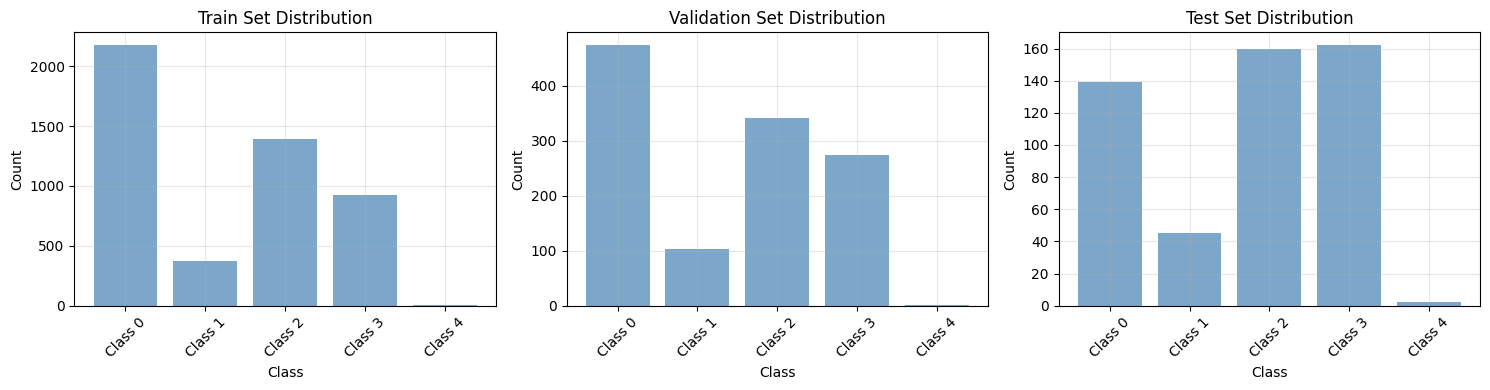

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, labels, title in zip(axes, 
                              [train_labels, valid_labels, test_labels],
                              ['Train', 'Validation', 'Test']):
    unique, counts = np.unique(labels, return_counts=True)
    class_names = [f'Class {int(u)}' for u in unique]
    
    ax.bar(class_names, counts, alpha=0.7, color='steelblue')
    ax.set_title(f'{title} Set Distribution')
    ax.set_ylabel('Count')
    ax.set_xlabel('Class')
    ax.grid(alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Block 7: Visualize Sample Images


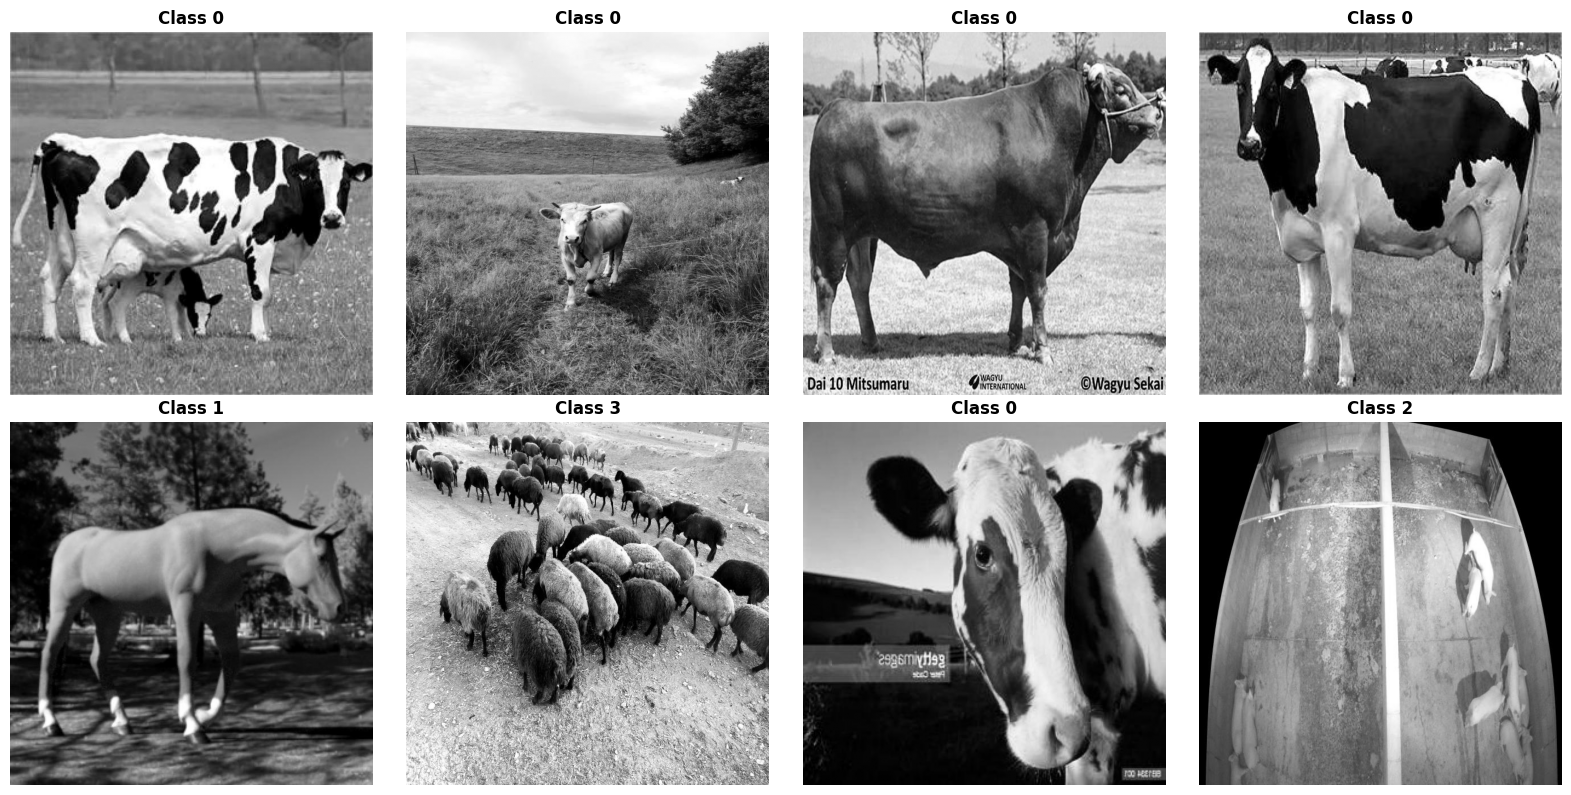

In [7]:
def visualize_samples(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        
        if isinstance(img, torch.Tensor):
            img = img.squeeze().numpy()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Class {label}', fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
    plt.show()

visualize_samples(train_dataset)

# Block 8: Calculate Class Weights


In [8]:
unique, counts = np.unique(train_labels, return_counts=True)
num_classes = len(unique)
total_samples = len(train_labels)

class_weights = [total_samples / (num_classes * count) for count in counts]
class_weights = torch.FloatTensor(class_weights).to(device)

print("\nClass Weights (for handling imbalance):")
for i, w in enumerate(class_weights):
    print(f"  Class {i}: {w:.4f}")


Class Weights (for handling imbalance):
  Class 0: 0.4477
  Class 1: 2.6308
  Class 2: 0.6983
  Class 3: 1.0569
  Class 4: 121.6750


# Block 9: Create Summary Statistics


In [9]:
dataset_stats = {
    'num_classes': num_classes,
    'train_size': len(train_dataset),
    'valid_size': len(valid_dataset),
    'test_size': len(test_dataset),
    'class_distribution': {
        'train': dict(zip(*np.unique(train_labels, return_counts=True))),
        'valid': dict(zip(*np.unique(valid_labels, return_counts=True))),
        'test': dict(zip(*np.unique(test_labels, return_counts=True)))
    },
    'img_size': 640,
    'channels': 1
}

for key, value in dataset_stats.items():
    print(f"{key}: {value}")

num_classes: 5
train_size: 4867
valid_size: 1195
test_size: 508
class_distribution: {'train': {np.int64(0): np.int64(2174), np.int64(1): np.int64(370), np.int64(2): np.int64(1394), np.int64(3): np.int64(921), np.int64(4): np.int64(8)}, 'valid': {np.int64(0): np.int64(474), np.int64(1): np.int64(103), np.int64(2): np.int64(342), np.int64(3): np.int64(275), np.int64(4): np.int64(1)}, 'test': {np.int64(0): np.int64(139), np.int64(1): np.int64(45), np.int64(2): np.int64(160), np.int64(3): np.int64(162), np.int64(4): np.int64(2)}}
img_size: 640
channels: 1


# Block 10: Save Preprocessed Data


In [10]:
os.makedirs('checkpoints', exist_ok=True)

torch.save(class_weights, 'checkpoints/class_weights.pth')

import pickle
with open('checkpoints/dataset_stats.pkl', 'wb') as f:
    pickle.dump(dataset_stats, f)

print("\n✅ Saved:")
print("  - checkpoints/class_weights.pth")
print("  - checkpoints/dataset_stats.pkl")
print("\n📊 Notebook 1: Data Preparation COMPLETE!")


✅ Saved:
  - checkpoints/class_weights.pth
  - checkpoints/dataset_stats.pkl

📊 Notebook 1: Data Preparation COMPLETE!
